In [41]:
import os 
import numpy as np 
import math 
import json 
from functools import partial 

import matplotlib.pyplot as plt 
plt.set_cmap('cividis')
%matplotlib inline 
import seaborn as sns 
sns.set_theme()

from tqdm.auto import tqdm 

import jax 
import jax.numpy as jnp 
import jax.random as random

main_rng = jax.random.key(42)

import flax 
from flax import linen as nn 
from flax.training import train_state, orbax_utils

import optax 
import orbax 

import torch 
import torch.utils.data as data 
from torch.utils.tensorboard import SummaryWriter
import torchvision 
from torchvision import transforms 
from torchvision.datasets import CIFAR100 

<Figure size 640x480 with 0 Axes>

In [42]:
BASE_PATH = "/Users/nikhilpaleti/Documents/GPU_programming/jax"
DATASET_PATH = os.path.join(BASE_PATH, 'data')
CHECKPOINT_PATH = os.path.join(BASE_PATH, 'checkpoints')

In [43]:
print(f'{jax.devices()=}')

jax.devices()=[CpuDevice(id=0)]


In [44]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = k.shape[-1]
    attn_logits = jnp.matmul(q, jnp.swapaxes(k, -2, -1))
    attn_logits = attn_logits / jnp.sqrt(d_k)
    if mask is not None:
        attn_logits = jnp.where(mask==0, -9e15, attn_logits)
    attention = nn.softmax(attn_logits, axis=-1)
    values = jnp.matmul(attention, v)
    return values, attention

In [45]:
seq_len, d_k = 3, 2
main_rng, rand1 = jax.random.split(main_rng)
qkv = jax.random.normal(rand1, (3, seq_len, d_k))
q, k, v = qkv[0], qkv[1], qkv[2]
values, attention = scaled_dot_product(q, k, v)
print(f'{q=} \n{k=} \n{v=} \n{values=} \n{attention=}')

q=Array([[ 0.60576403,  0.7990441 ],
       [-0.908927  , -0.63525754],
       [-1.2226585 , -0.83226097]], dtype=float32) 
k=Array([[-0.47417238, -1.2504351 ],
       [-0.17678244, -0.04917514],
       [-0.41177532, -0.39363015]], dtype=float32) 
v=Array([[ 1.3116323 ,  0.21555556],
       [ 0.41164538, -0.28955024],
       [-0.96516913,  0.4492738 ]], dtype=float32) 
values=Array([[0.12734914, 0.06441191],
       [0.4115729 , 0.17320421],
       [0.46902645, 0.1854193 ]], dtype=float32) 
attention=Array([[0.20383833, 0.4564296 , 0.33973208],
       [0.46830934, 0.2255167 , 0.30617398],
       [0.51187545, 0.19520193, 0.29292265]], dtype=float32)


In [46]:
def expand_mask(mask):
    assert mask.ndim >=2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask 

In [47]:
class MultiheadAttention(nn.Module):
    embed_dim: int 
    num_heads: int 

    def setup(self):
        self.qkv_proj = nn.Dense(3*self.embed_dim,
                                 kernel_init=nn.initializers.xavier_uniform(),
                                 bias_init=nn.initializers.zeros)
        self.o_proj = nn.Dense(self.embed_dim,
                               kernel_init=nn.initializers.xavier_uniform(),
                               bias_init=nn.initializers.zeros)
    
    def __call__(self, x, mask=None):
        batch_size, seq_len, embed_dim = x.shape
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)

        qkv = qkv.reshape(batch_size, seq_len, self.num_heads, -1)
        qkv = qkv.transpose(0, 2, 1, 3)
        q, k, v = jnp.array_split(qkv, 3, axis=-1)

        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.transpose(0, 2, 1, 3)
        values = values.reshape(batch_size, seq_len, embed_dim)
        o = self.o_proj(values)

        return o, attention

In [48]:
main_rng, x_rng = jax.random.split(main_rng)
x = jax.random.normal(x_rng, (3, 16, 128))
# Create attention
mh_attn = MultiheadAttention(embed_dim=128, num_heads=4)
# Initialize parameters of attention with random key and inputs
main_rng, init_rng = jax.random.split(main_rng)
params = mh_attn.init(init_rng, x)['params']
# Apply attention with parameters on the inputs
out, attn = mh_attn.apply({'params': params}, x)
print('Out', out.shape, 'Attention', attn.shape)

del mh_attn, params

Out (3, 16, 128) Attention (3, 4, 16, 16)


In [49]:
class EncoderBlock(nn.Module):
    input_dim: int
    num_heads: int 
    dim_feedforward: int 
    dropout_prob: int 

    def setup(self):
        self.self_attn = MultiheadAttention(embed_dim=self.input_dim,
                                            num_heads=self.num_heads)
        
        self.linear = [
            nn.Dense(self.dim_feedforward),
            nn.Dropout(self.dropout_prob),
            nn.relu,
            nn.Dense(self.input_dim)
        ]

        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()
        self.dropout = nn.Dropout(self.dropout_prob)
    
    def __call__(self, x, mask=None, train=True):
        attn_out, _ = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out, deterministic= not train)
        x = self.norm1(x)

        linear_out = x 
        for l in self.linear:
            linear_out = l(linear_out) if not isinstance(l, nn.Dropout) else l(linear_out, deterministic= not train)
        x = x + self.dropout(linear_out, deterministic=not train)
        x = self.norm2(x)

        return x

In [50]:
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))

encblock = EncoderBlock(input_dim=128, num_heads=4, dim_feedforward=512, dropout_prob=0.1)
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = encblock.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
main_rng, dropout_apply_rng = random.split(main_rng)
out = encblock.apply({'params': params}, x, train=True, rngs={'dropout': dropout_apply_rng})
print('Out', out.shape)
del encblock, params

Out (3, 16, 128)


In [51]:
class TransformerEncoder(nn.Module):
    num_layers : int
    input_dim : int
    num_heads : int
    dim_feedforward : int
    dropout_prob : float

    def setup(self):
        self.layers = [EncoderBlock(self.input_dim, self.num_heads, self.dim_feedforward, self.dropout_prob) for _ in range(self.num_layers)]

    def __call__(self, x, mask=None, train=True):
        for l in self.layers:
            x = l(x, mask=mask, train=train)
        return x
    
    def get_attention_maps(self, x, mask=None, train=True):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask)
            attention_maps.append(attn_map)
            x = l(x, mask=mask, train=train)
        return attention_maps

In [52]:
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 128))

transenc = TransformerEncoder(num_layers=5,
                              input_dim=128,
                              num_heads=4,
                              dim_feedforward=256,
                              dropout_prob=0.15)

main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transenc.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']

main_rng, dropout_apply_rng = random.split(main_rng)
binded_mod = transenc.bind({'params': params}, rngs={'dropout': dropout_apply_rng})
out = binded_mod(x, train=True)
print('Out', out.shape)
attn_maps = binded_mod.get_attention_maps(x, train=True)
print('Attention maps', len(attn_maps), attn_maps[0].shape)

del transenc, binded_mod, params

Out (3, 16, 128)
Attention maps 5 (3, 4, 16, 16)


In [53]:
class PositionalEncoding(nn.Module):
    d_model : int         # Hidden dimensionality of the input.
    max_len : int = 5000  # Maximum length of a sequence to expect.

    def setup(self):
        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = np.zeros((self.max_len, self.d_model))
        position = np.arange(0, self.max_len, dtype=np.float32)[:,None]
        div_term = np.exp(np.arange(0, self.d_model, 2) * (-math.log(10000.0) / self.d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[None]
        self.pe = jax.device_put(pe)

    def __call__(self, x):
        x = x + self.pe[:, :x.shape[1]]
        return x

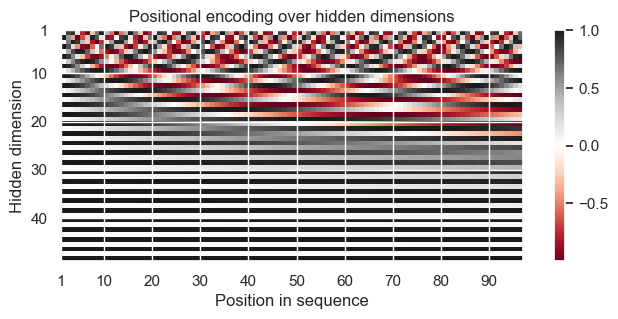

In [54]:
encod_block = PositionalEncoding(d_model=48, max_len=96).bind({})
pe = jax.device_get(encod_block.pe.squeeze().T)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

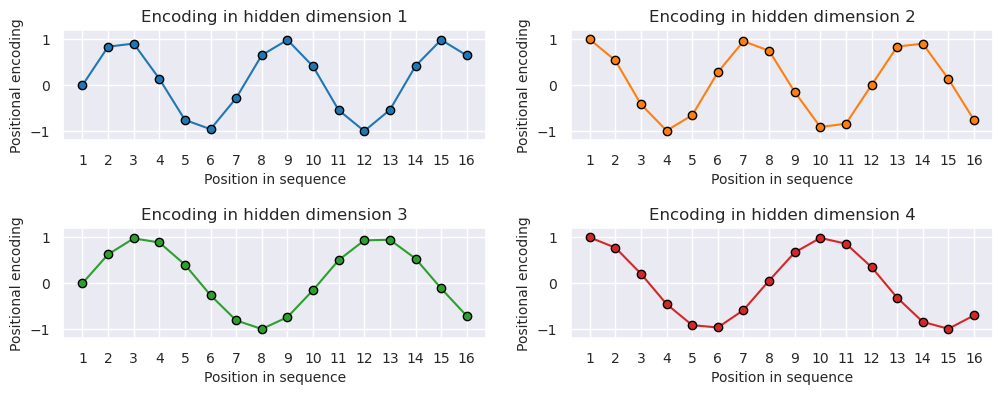

In [55]:
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

In [56]:
def cosine_warmup_schedule(base_lr: float, warmup: int, max_iters: int):
    assert warmup > 0 and max_iters > 0
    # Create function to return lr based on iteration count
    def get_lr(train_iter):
        lr_factor = 0.5 * (1 + np.cos(np.pi * train_iter / max_iters))
        if train_iter <= warmup:
            lr_factor *= train_iter * 1.0 / warmup
        return lr_factor * base_lr
    return get_lr

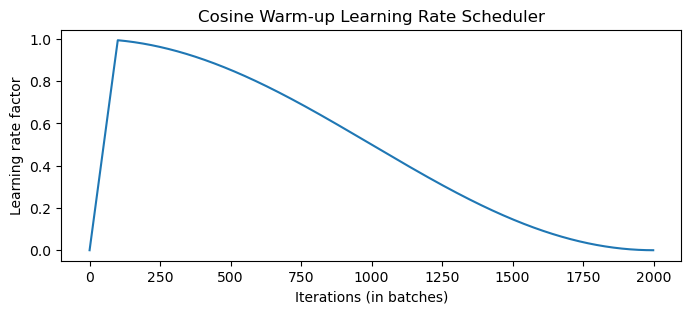

In [57]:
lr_scheduler = cosine_warmup_schedule(base_lr=1.0, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

In [58]:
class TransformerPredictor(nn.Module):
    model_dim : int                   # Hidden dimensionality to use inside the Transformer
    num_classes : int                 # Number of classes to predict per sequence element
    num_heads : int                   # Number of heads to use in the Multi-Head Attention blocks
    num_layers : int                  # Number of encoder blocks to use
    dropout_prob : float = 0.0        # Dropout to apply inside the model
    input_dropout_prob : float = 0.0  # Dropout to apply on the input features

    def setup(self):
        # Input dim -> Model dim
        self.input_dropout = nn.Dropout(self.input_dropout_prob)
        self.input_layer = nn.Dense(self.model_dim)
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(self.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.num_layers,
                                              input_dim=self.model_dim,
                                              dim_feedforward=2*self.model_dim,
                                              num_heads=self.num_heads,
                                              dropout_prob=self.dropout_prob)
        # Output classifier per sequence lement
        self.output_net = [
            nn.Dense(self.model_dim),
            nn.LayerNorm(),
            nn.relu,
            nn.Dropout(self.dropout_prob),
            nn.Dense(self.num_classes)
        ]

    def __call__(self, x, mask=None, add_positional_encoding=True, train=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
            train - If True, dropout is stochastic
        """
        x = self.input_dropout(x, deterministic=not train)
        x = self.input_layer(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask, train=train)
        for l in self.output_net:
            x = l(x) if not isinstance(l, nn.Dropout) else l(x, deterministic=not train)
        return x

    def get_attention_maps(self, x, mask=None, add_positional_encoding=True, train=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_dropout(x, deterministic=not train)
        x = self.input_layer(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask, train=train)
        return attention_maps

In [59]:
main_rng, x_rng = random.split(main_rng)
x = random.normal(x_rng, (3, 16, 64))
# Create Transformer encoder
transpre = TransformerPredictor(num_layers=5,
                                model_dim=128,
                                num_classes=10,
                                num_heads=4,
                                dropout_prob=0.15,
                                input_dropout_prob=0.05)
# Initialize parameters of transformer predictor with random key and inputs
main_rng, init_rng, dropout_init_rng = random.split(main_rng, 3)
params = transpre.init({'params': init_rng, 'dropout': dropout_init_rng}, x, train=True)['params']
# Apply transformer predictor with parameters on the inputs
# Since dropout is stochastic, we need to pass a rng to the forward
main_rng, dropout_apply_rng = random.split(main_rng)
# Instead of passing params and rngs every time to a function call, we can bind them to the module
binded_mod = transpre.bind({'params': params}, rngs={'dropout': dropout_apply_rng})
out = binded_mod(x, train=True)
print('Out', out.shape)
attn_maps = binded_mod.get_attention_maps(x, train=True)
print('Attention maps', len(attn_maps), attn_maps[0].shape)

del transpre, binded_mod, params

Out (3, 16, 10)
Attention maps 5 (3, 4, 16, 16)


In [60]:
import orbax.checkpoint


class TrainerModule:

    def __init__(self, model_name, exmp_batch, max_iters, lr=1e-3, warmup=100, seed=42, **model_kwargs):
        super().__init__()
        self.model_name = model_name
        self.max_iters = max_iters
        self.lr = lr 
        self.warmup = warmup 
        self.seed = seed
        self.model = TransformerPredictor(**model_kwargs)
        self.log_dir = os.path.join(CHECKPOINT_PATH, self.model_name)
        self.logger = SummaryWriter(log_dir=self.log_dir)
        self.create_functions()
        self.init_model(exmp_batch)
    
    def batch_to_input(self, exmp_batch):
        raise NotImplementedError
    
    def get_loss_function(self):
        raise NotImplementedError
    
    def create_functions(self):
        calculate_loss = self.get_loss_function()
        def train_step(state, rng, batch):
            loss_fn = lambda params: calculate_loss(params, rng, batch, train=True)
            ret, grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            loss, acc, rng = ret[0], *ret[1]
            state = state.apply_gradients(grads=grads)
            return state, rng, loss, acc
        self.train_step = jax.jit(train_step)

        def eval_step(state, rng, batch):
            _, (acc, rng) = calculate_loss(state.params, rng, batch, train=False)
            return acc, rng 
        self.eval_step = eval_step
    
    def init_model(self, exmp_batch):
        self.rng = random.key(self.seed)
        self.rng, init_rng, dropout_rng = random.split(self.rng, 3)
        exmp_input = self.batch_to_input(exmp_batch)
        params = self.model.init({'params': init_rng, 'dropout': dropout_init_rng}, exmp_input, train=True)['params']
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=self.lr,
            warmup_steps=self.warmup,
            decay_steps=self.max_iters,
            end_value=0.0
        )
        optimizer = optax.chain(
            optax.clip_by_global_norm(1.0),
            optax.adam(lr_schedule)
        )
        self.state = train_state.TrainState.create(apply_fn=self.model.apply,
                                                   params=params,
                                                   tx=optimizer)
        
        options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=2, create=True)
        self.checkpointer = orbax.checkpoint.PyTreeCheckpointer()
        self.checkpoint_manager = orbax.checkpoint.CheckpointManager(
            self.log_dir + '/'+self.model_name, 
            self.checkpointer,
            options
        )
    
    def train_model(self, train_loader, val_loader, num_epochs=500):
        best_acc = 0.0
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            if epoch_idx % 5 == 0:
                eval_acc = self.eval_model(val_loader)
                self.logger.add_scalar('val/accuracy', eval_acc, global_step=epoch_idx)
                if eval_acc >= best_acc:
                    best_acc = eval_acc
                    self.save_model(step=epoch_idx)
                self.logger.flush()
    
    def train_epoch(self, train_loader, epoch):
        accs, losses = [], []
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, self.rng, loss, accuracy = self.train_step(self.state, self.rng, batch)
            losses.append(loss)
            accs.append(accuracy)
        
        avg_loss = np.stack(jax.device_get(losses)).mean()
        avg_acc = np.stack(jax.device_get(accs)).mean()
        self.logger.add_scalar('train/loss', avg_loss, global_step=epoch)
        self.logger.add_scalar('train/acc', avg_acc, global_step=epoch)
    
    def eval_model(self, data_loader):
        correct_class, count = 0, 0
        for batch in data_loader:
            acc, self.rng = self.eval_step(self.state, self.rng, batch)
            correct_class += acc * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_acc = (correct_class / count).item()
        return eval_acc
    
    def save_model(self, step=0):

        ckpt = {
            'model': self.state.params
        }
        save_args = orbax_utils.save_args_from_target(ckpt)
        self.checkpoint_manager.save(step, ckpt, save_kwargs={'save_args': save_args})
    
    def load_model(self):
        step = self.checkpoint_manager.latest_step()
        params = self.checkpoint_manager.restore(step)['model']
        self.state = train_state.TrainState.create(
            apply_fn=self.model.apply,
            params = params, 
            tx = self.state.tx
        )
    
    def checkpoint_exists(self):
        return False 
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'))


In [61]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size, np_rng):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size 
        self.np_rng = np_rng
    
        self.data = self.np_rng.integers(self.num_categories, size=(self.size, self.seq_len))
    
    def __len__(self):
        return self.size 

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = np.flip(inp_data, axis=0)
        return inp_data, labels

In [62]:
# Combine batch elements (all numpy) by stacking
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

dataset = partial(ReverseDataset, 10, 16)
rev_train_loader = data.DataLoader(dataset(50000, np_rng=np.random.default_rng(42)),
                                   batch_size=128,
                                   shuffle=True,
                                   drop_last=True,
                                   collate_fn=numpy_collate)
rev_val_loader   = data.DataLoader(dataset(1000, np_rng=np.random.default_rng(43)),
                                   batch_size=128,
                                   collate_fn=numpy_collate)
rev_test_loader  = data.DataLoader(dataset(10000, np_rng=np.random.default_rng(44)),
                                   batch_size=128,
                                   collate_fn=numpy_collate)

In [63]:
inp_data, labels = rev_train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: [0 7 6 4 4 8 0 6 2 0 5 9 7 7 7 7]
Labels:     [7 7 7 7 9 5 0 2 6 0 8 4 4 6 7 0]


In [64]:
class ReverseTrainer(TrainerModule):

    def batch_to_input(self, batch):
        inp_data, _ = batch 
        inp_data = jax.nn.one_hot(inp_data, num_classes=self.model.num_classes)
        return inp_data

    def get_loss_function(self):
        def calculate_loss(params, rng, batch, train):
            inp_data, labels = batch 
            inp_data = jax.nn.one_hot(inp_data, num_classes=self.model.num_classes)
            rng, dropout_apply_rng = random.split(rng)
            logits = self.model.apply({'params': params}, inp_data, train=train, rngs={'dropout': dropout_apply_rng})
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (logits.argmax(axis=-1) == labels).mean()
            return loss, (acc, rng)
        return calculate_loss

In [65]:
def train_reverse(max_epochs=10, **model_args):
    num_train_iters = len(rev_train_loader) * max_epochs
    trainer = ReverseTrainer(model_name='ReverseTask',
                             exmp_batch=next(iter(rev_train_loader)),
                             max_iters=num_train_iters,
                             **model_args)
    
    trainer.train_model(rev_train_loader, rev_val_loader, num_epochs=max_epochs)
    trainer.load_model()

    val_acc = trainer.eval_model(rev_val_loader)
    test_acc = trainer.eval_model(rev_test_loader)
    trainer.model_bd = trainer.model.bind({'params': trainer.state.params})
    return trainer, {'val_acc': val_acc, 'test_acc': test_acc}

In [66]:
reverse_trainer, reverse_result = train_reverse(model_dim=32,
                                                num_heads=1,
                                                num_classes=rev_train_loader.dataset.num_categories,
                                                num_layers=1,
                                                dropout_prob=0.0,
                                                lr=5e-4,
                                                warmup=50)

100%|██████████| 10/10 [00:10<00:00,  1.06s/it]
/opt/anaconda3/envs/jax/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [67]:
print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

Val accuracy:  100.00%
Test accuracy: 100.00%


In [68]:
data_input, labels = next(iter(rev_val_loader))
inp_data = jax.nn.one_hot(data_input, num_classes=reverse_trainer.model.num_classes)
attention_maps = reverse_trainer.model_bd.get_attention_maps(inp_data)

In [69]:
attention_maps[0].shape

(128, 1, 16, 16)

In [70]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = jax.device_get(input_data[idx])
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [jax.device_get(m[idx]) for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

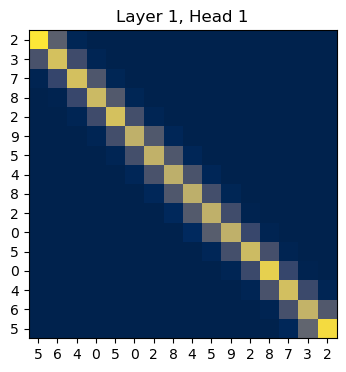

In [71]:
plot_attention_maps(data_input, attention_maps, idx=0)